In [4]:
from Bio import SeqIO
import h5py
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

In [5]:
def load_sequences_from_fasta(file_path):
    sequences = {}
    for record in SeqIO.parse(file_path, "fasta"):
        sequences[record.id] = str(record.seq)
    return sequences

train_sequences = load_sequences_from_fasta(r"/kaggle/input/dataset/data/biological_data_pfp/train/train.fasta")

In [6]:
def load_embeddings(file_path):
    embeddings = {}
    with h5py.File(file_path, 'r') as h5_file:
        for protein_id in h5_file.keys():
            embeddings[protein_id] = np.array(h5_file[protein_id])
    return embeddings

train_embeddings = load_embeddings(r"/kaggle/input/dataset/data/biological_data_pfp/train/train_embeddings.h5")


In [7]:
def load_annotations(file_path,):
    annotations = pd.read_csv(file_path, sep='\t')
    return annotations

train_annotations = load_annotations(r"/kaggle/input/dataset/data/biological_data_pfp/train/train_set.tsv")

In [8]:
train_annotations

,Protein_ID,aspect,GO_term
0,P91124,cellular_component,GO:0005575
1,P91124,cellular_component,GO:0110165
2,P91124,cellular_component,GO:0005737
3,P91124,cellular_component,GO:0005622
4,P91124,cellular_component,GO:0043226
...,...,...,...
4277042,P28271,biological_process,GO:0010608
4277043,P28271,biological_process,GO:0080090
4277044,P28271,biological_process,GO:0006417
4277045,P28271,biological_process,GO:0051246


In [9]:
#1, 2, 3 datsets respectively represent the cellular_component, Molecular_function ,and Biological_process chracteristics
X1_T = train_annotations.loc[train_annotations["aspect"] == "cellular_component"]
X2_T = train_annotations.loc[train_annotations["aspect"] == "molecular_function"]
X3_T = train_annotations.loc[train_annotations["aspect"] == "biological_process"]

In [11]:
def encode_go_terms(annotations):
    # Group by Protein_ID and aggregate GO_IDs into lists
    grouped = annotations.groupby('Protein_ID')['GO_term'].apply(set).reset_index()
    
    # Prepare for multi-label binarizer
    go_terms = grouped['GO_term'].values.tolist()
    
    mlb = MultiLabelBinarizer()
    encoded_go_terms = mlb.fit_transform(go_terms)
    
    return grouped['Protein_ID'].values, encoded_go_terms, mlb.classes_

In [12]:
protein_ids_X1_enc, encoded_go_terms_X1_enc, go_classes_X1_enc = encode_go_terms(X1_T)
protein_ids_X2_enc, encoded_go_terms_X2_enc, go_classes_X2_enc = encode_go_terms(X2_T)
protein_ids_X3_enc, encoded_go_terms_X3_enc, go_classes_X3_enc = encode_go_terms(X3_T)

In [13]:
protein_ids_X1_enc

array(['A0A021WW32', 'A0A021WZA4', 'A0A023GPJ3', ..., 'X6RLP6', 'X6RLR1',
       'X6RM59'], dtype=object)

In [14]:
def prepare_dataset(protein_ids, embeddings, encoded_go_terms):
    # Filter embeddings to only include proteins with annotations
    filtered_embeddings = [embeddings[pid] for pid in protein_ids if pid in embeddings]
    filtered_labels = encoded_go_terms[[pid in embeddings for pid in protein_ids]]
    
    # Convert to numpy arrays
    X = np.array(filtered_embeddings)
    y = np.array(filtered_labels)
    
    return X, y

In [15]:
X_1, y_1 = prepare_dataset(protein_ids_X1_enc, train_embeddings, encoded_go_terms_X1_enc)

In [16]:
X_2, y_2 = prepare_dataset(protein_ids_X2_enc, train_embeddings, encoded_go_terms_X2_enc)

In [17]:
X_3, y_3 = prepare_dataset(protein_ids_X3_enc, train_embeddings, encoded_go_terms_X3_enc)

In [18]:
#Creating dataset to feed into tensorflow

In [19]:
import tensorflow as tf

features_1 = X_1
labels_1 = y_1

features_2 = X_2
labels_2 = y_2

features_3 = X_3
labels_3 = y_3
# Create a TensorFlow dataset from the features and labels
dataset_1 = tf.data.Dataset.from_tensor_slices((features_1, labels_1))
dataset_2 = tf.data.Dataset.from_tensor_slices((features_2, labels_2))
dataset_3 = tf.data.Dataset.from_tensor_slices((features_3, labels_3))

# Shuffle the dataset
# Ensure buffer_size is greater than or equal to the size of the dataset
#buffer_size_1 = len(features_1)
#shuffled_dataset_1 = dataset_1.shuffle(buffer_size=buffer_size_1, seed=42)

#buffer_size_2 = len(features_2)
#shuffled_dataset_2 = dataset_2.shuffle(buffer_size=buffer_size_2, seed=42)

#buffer_size_3 = len(features_3)
#shuffled_dataset_3 = dataset_3.shuffle(buffer_size=buffer_size_3, seed=42)

2024-02-20 13:43:55.491987: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 13:43:55.492118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 13:43:55.670444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [20]:
# Calculate the size of each dataset split(0.7, 0.15, 0.15)
total_size_1 = len(features_1)
train_size_1 = int(0.7 * total_size_1)
val_size_1 = int(0.15 * total_size_1)
test_size_1 = total_size_1 - train_size_1 - val_size_1  # Remaining data for test

total_size_2 = len(features_2)
train_size_2 = int(0.7 * total_size_2)
val_size_2 = int(0.15 * total_size_2)
test_size_2 = total_size_2 - train_size_2 - val_size_2 

total_size_3 = len(features_3)
train_size_3 = int(0.7 * total_size_3)
val_size_3 = int(0.15 * total_size_3)
test_size_3 = total_size_3 - train_size_3 - val_size_3

train_dataset_1 = dataset_1.take(train_size_1)
test_dataset_1 = dataset_1.skip(train_size_1)
val_dataset_1 = test_dataset_1.skip(test_size_1)
test_dataset_1 = test_dataset_1.take(test_size_1)

train_dataset_2 = dataset_2.take(train_size_2)
test_dataset_2 = dataset_2.skip(train_size_2)
val_dataset_2 = test_dataset_2.skip(test_size_2)
test_dataset_2 = test_dataset_2.take(test_size_2)

train_dataset_3 = dataset_3.take(train_size_3)
test_dataset_3 = dataset_3.skip(train_size_3)
val_dataset_3 = test_dataset_3.skip(test_size_3)
test_dataset_3 = test_dataset_3.take(test_size_3)

# Split the dataset
#train_dataset_1 = shuffled_dataset_1.take(train_size_1)
#test_dataset_1 = shuffled_dataset_1.skip(train_size_1)
#val_dataset_1 = test_dataset_1.skip(test_size_1)
#test_dataset_1 = test_dataset_1.take(test_size_1)

#train_dataset_2 = shuffled_dataset_2.take(train_size_2)
#test_dataset_2 = shuffled_dataset_2.skip(train_size_2)
#val_dataset_2 = test_dataset_2.skip(test_size_2)
#test_dataset_2 = test_dataset_2.take(test_size_2)

#train_dataset_3 = shuffled_dataset_3.take(train_size_3)
#test_dataset_3 = shuffled_dataset_3.skip(train_size_3)
#val_dataset_3 = test_dataset_3.skip(test_size_3)
#test_dataset_ = test_dataset_3.take(test_size_3)

In [21]:
batch_size = 128
train_dataset_1 = train_dataset_1.batch(batch_size)
val_dataset_1 = val_dataset_1.batch(batch_size)
test_dataset_1 = test_dataset_1.batch(batch_size)

train_dataset_2 = train_dataset_2.batch(batch_size)
val_dataset_2 = val_dataset_2.batch(batch_size)
test_dataset_2 = test_dataset_2.batch(batch_size)

train_dataset_3 = train_dataset_3.batch(batch_size)
val_dataset_3 = val_dataset_3.batch(batch_size)
test_dataset_3 = test_dataset_3.batch(batch_size)

In [22]:
train_dataset_2

<_BatchDataset element_spec=(TensorSpec(shape=(None, 1024), dtype=tf.float16, name=None), TensorSpec(shape=(None, 839), dtype=tf.int64, name=None))>

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

def build_model(input_dim, num_classes):
    model = Sequential([
        Dense(5000, activation='relu', input_shape=(input_dim,)),
        Dense(4000, activation='relu'),
        Dense(4000, activation='relu'),
        Dense(3000, activation='relu'),
        Dense(3000, activation='relu'),
        Dense(num_classes, activation='sigmoid')
    ])
    return model
model_1 = build_model(input_dim=1024,  # Your vector size
                    num_classes=678)  # Example value, adjust based on your GO terms

model_1.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5000)              5125000   
                                                                 
 dense_1 (Dense)             (None, 4000)              20004000  
                                                                 
 dense_2 (Dense)             (None, 4000)              16004000  
                                                                 
 dense_3 (Dense)             (None, 3000)              12003000  
                                                                 
 dense_4 (Dense)             (None, 3000)              9003000   
                                                                 
 dense_5 (Dense)             (None, 678)               2034678   
                                                                 
Total params: 64173678 (244.80 MB)
Trainable params: 641

In [24]:
history_1 = model_1.fit(train_dataset_1, epochs=20, validation_data=val_dataset_1)

Epoch 1/20


I0000 00:00:1708436657.012267     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


463/463 [==============================] - 18s 30ms/step - loss: 0.0695 - accuracy: 0.8671 - precision: 0.5442 - recall: 0.4254 - val_loss: 0.0491 - val_accuracy: 0.8517 - val_precision: 0.8002 - val_recall: 0.4173
Epoch 2/20
463/463 [==============================] - 13s 28ms/step - loss: 0.0468 - accuracy: 0.8782 - precision: 0.7599 - recall: 0.4374 - val_loss: 0.0453 - val_accuracy: 0.8517 - val_precision: 0.8687 - val_recall: 0.4222
Epoch 3/20
463/463 [==============================] - 13s 28ms/step - loss: 0.0426 - accuracy: 0.8782 - precision: 0.7991 - recall: 0.4633 - val_loss: 0.0417 - val_accuracy: 0.8517 - val_precision: 0.8523 - val_recall: 0.4668
Epoch 4/20
463/463 [==============================] - 13s 29ms/step - loss: 0.0398 - accuracy: 0.8782 - precision: 0.8060 - recall: 0.4912 - val_loss: 0.0396 - val_accuracy: 0.8517 - val_precision: 0.8445 - val_recall: 0.4917
Epoch 5/20
463/463 [==============================] - 13s 29ms/step - loss: 0.0374 - accuracy: 0.8782 - pre

In [25]:
test_loss, test_acc, test_precision, test_recall = model_1.evaluate(val_dataset_1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

100/100 [==============================] - 1s 6ms/step - loss: 0.0401 - accuracy: 0.8514 - precision: 0.7863 - recall: 0.5859
Test Loss: 0.040053609758615494
Test Accuracy: 0.8513588309288025
Test Precision: 0.7862542867660522
Test Recall: 0.5859357118606567


In [26]:
predictions = model_1.predict(test_dataset_1)
binary_predictions = np.where(predictions > 0.5, 1, 0)

100/100 [==============================] - 1s 5ms/step


In [27]:
protein_ids_X1_enc

array(['A0A021WW32', 'A0A021WZA4', 'A0A023GPJ3', ..., 'X6RLP6', 'X6RLR1',
       'X6RM59'], dtype=object)

In [28]:
top_three_indices = np.argsort(predictions, axis=1)[:, -3:]
top_three_probs = np.sort(predictions, axis=1)[:, -3:]
top_three_terms = np.vectorize(lambda x: go_classes_X1_enc[x])(top_three_indices)
protein_go_terms_probs = []
for i, j in enumerate(go_classes_X1_enc):
    go_terms_with_probs = list(zip(top_three_terms[i], top_three_probs[i]))
    protein_go_terms_probs.append((protein_ids_X1_enc, go_terms_with_probs))
o = 0
for protein_ids_X1_enc, go_terms_with_probs in protein_go_terms_probs[:5]:  # Adjust the slice for your needs
    print(f"Protein ID: {protein_ids_X1_enc[o]}")
    o+=1
    for go_term, prob in go_terms_with_probs:
        print(f"  GO Term: {go_term}, Probability: {prob:.4f}")
    print("---")

Protein ID: A0A021WW32
  GO Term: GO:0005622, Probability: 0.9975
  GO Term: GO:0110165, Probability: 1.0000
  GO Term: GO:0005575, Probability: 1.0000
---
Protein ID: A0A021WZA4
  GO Term: GO:0005622, Probability: 0.9948
  GO Term: GO:0110165, Probability: 1.0000
  GO Term: GO:0005575, Probability: 1.0000
---
Protein ID: A0A023GPJ3
  GO Term: GO:0005622, Probability: 1.0000
  GO Term: GO:0110165, Probability: 1.0000
  GO Term: GO:0005575, Probability: 1.0000
---
Protein ID: A0A023GUT0
  GO Term: GO:0005622, Probability: 0.9990
  GO Term: GO:0110165, Probability: 1.0000
  GO Term: GO:0005575, Probability: 1.0000
---
Protein ID: A0A023IM54
  GO Term: GO:0071944, Probability: 0.9574
  GO Term: GO:0110165, Probability: 1.0000
  GO Term: GO:0005575, Probability: 1.0000
---


In [29]:
model_2 = build_model(input_dim=1024,  # Your vector size
                    num_classes=839)  # Example value, adjust based on your GO terms

model_2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 5000)              5125000   
                                                                 
 dense_7 (Dense)             (None, 4000)              20004000  
                                                                 
 dense_8 (Dense)             (None, 4000)              16004000  
                                                                 
 dense_9 (Dense)             (None, 3000)              12003000  
                                                                 
 dense_10 (Dense)            (None, 3000)              9003000   
                                                                 
 dense_11 (Dense)            (None, 839)               2517839   
                                                                 
Total params: 64656839 (246.65 MB)
Trainable params: 6

In [30]:
history_2 = model_2.fit(train_dataset_2, epochs=20, validation_data=val_dataset_2)

Epoch 1/20
305/305 [==============================] - 12s 32ms/step - loss: 0.0733 - accuracy: 0.7892 - precision_1: 0.2600 - recall_1: 0.2102 - val_loss: 0.0397 - val_accuracy: 0.8603 - val_precision_1: 0.8000 - val_recall_1: 0.2160
Epoch 2/20
305/305 [==============================] - 9s 31ms/step - loss: 0.0396 - accuracy: 0.8417 - precision_1: 0.8060 - recall_1: 0.2503 - val_loss: 0.0346 - val_accuracy: 0.8603 - val_precision_1: 0.8120 - val_recall_1: 0.2876
Epoch 3/20
305/305 [==============================] - 9s 31ms/step - loss: 0.0341 - accuracy: 0.8417 - precision_1: 0.8111 - recall_1: 0.3061 - val_loss: 0.0295 - val_accuracy: 0.8603 - val_precision_1: 0.8253 - val_recall_1: 0.3518
Epoch 4/20
305/305 [==============================] - 9s 31ms/step - loss: 0.0297 - accuracy: 0.8417 - precision_1: 0.8042 - recall_1: 0.3746 - val_loss: 0.0265 - val_accuracy: 0.8603 - val_precision_1: 0.8243 - val_recall_1: 0.4021
Epoch 5/20
305/305 [==============================] - 9s 31ms/step 

In [31]:
test_loss, test_acc, test_precision, test_recall = model_2.evaluate(val_dataset_2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

66/66 [==============================] - 0s 6ms/step - loss: 0.0236 - accuracy: 0.8603 - precision_1: 0.7962 - recall_1: 0.5523
Test Loss: 0.023572685196995735
Test Accuracy: 0.860306441783905
Test Precision: 0.7962093353271484
Test Recall: 0.5523011088371277


In [32]:
predictions_2 = model_2.predict(test_dataset_2)

66/66 [==============================] - 1s 5ms/step


In [33]:
top_three_indices = np.argsort(predictions_2, axis=1)[:, -3:]
top_three_probs = np.sort(predictions_2, axis=1)[:, -3:]
top_three_terms = np.vectorize(lambda x: go_classes_X2_enc[x])(top_three_indices)
protein_go_terms_probs = []
for i, j in enumerate(go_classes_X2_enc):
    go_terms_with_probs = list(zip(top_three_terms[i], top_three_probs[i]))
    protein_go_terms_probs.append((protein_ids_X2_enc, go_terms_with_probs))
o = 0
for protein_ids_X2_enc, go_terms_with_probs in protein_go_terms_probs[:5]:  # Adjust the slice for your needs
    print(f"Protein ID: {protein_ids_X2_enc[o]}")
    o+=1
    for go_term, prob in go_terms_with_probs:
        print(f"  GO Term: {go_term}, Probability: {prob:.4f}")
    print("---")

Protein ID: A0A009IHW8
  GO Term: GO:0005515, Probability: 0.7314
  GO Term: GO:0005488, Probability: 0.9802
  GO Term: GO:0003674, Probability: 1.0000
---
Protein ID: A0A023FBW4
  GO Term: GO:0005515, Probability: 0.7973
  GO Term: GO:0005488, Probability: 0.9600
  GO Term: GO:0003674, Probability: 1.0000
---
Protein ID: A0A023FBW7
  GO Term: GO:0005515, Probability: 0.8009
  GO Term: GO:0005488, Probability: 0.8753
  GO Term: GO:0003674, Probability: 1.0000
---
Protein ID: A0A023FDY8
  GO Term: GO:0003676, Probability: 0.7861
  GO Term: GO:0005488, Probability: 0.9815
  GO Term: GO:0003674, Probability: 1.0000
---
Protein ID: A0A023FF81
  GO Term: GO:1901265, Probability: 0.9712
  GO Term: GO:0000166, Probability: 0.9765
  GO Term: GO:0003674, Probability: 1.0000
---


In [34]:
import math
class MyLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, method, params):
        self.initial_learning_rate = initial_learning_rate
        self.method = method
        self.params = params

    def __call__(self, step):
        if self.method == "FIX":
            return self.initial_learning_rate

        elif self.method == "STEP":
            gamma = self.params.get("gamma")
            l = self.params.get("l")
            return self.initial_learning_rate * tf.pow(gamma, tf.math.floor(tf.cast(step, tf.float32) / l))

        elif self.method == "EXP":
            gamma = self.params.get("gamma")
            return self.initial_learning_rate * tf.pow(gamma, tf.cast(step, tf.float32))

        elif self.method == "INV":
            gamma = self.params.get("gamma")
            p = self.params.get("p")
            return self.initial_learning_rate / tf.pow((1 + (gamma * tf.cast(step, tf.float32))), p)

        elif self.method == "POLY":
            l = self.params.get("l")
            p = self.params.get("p")
            return self.initial_learning_rate * tf.pow((1 - (tf.cast(step, tf.float32) / l)), p)

        elif self.method in ["TRI", "TRI2", "TRIEXP", "SIN", "SIN2", "SINEXP", "COS"]:
            l = self.params.get("l")
            k0 = self.initial_learning_rate
            k1 = self.params.get("k1")
            gamma = self.params.get("gamma")
            if self.method == "TRI":
                return k0 + (k1 - k0) * tf.abs(
                    tf.math.asin(tf.math.sin(math.pi * tf.cast(step, tf.float32) / (2 * l)))) / (2 / math.pi)
            elif self.method == "TRI2":
                    return k0 + (k1 - k0) * (1 / (tf.pow(2, tf.math.floor(tf.cast(step, tf.float32) / (2 * l))))) * tf.abs(
                        tf.math.asin(tf.math.sin(math.pi * tf.cast(step, tf.float32) / (2 * l)))) / (2 / math.pi)

            elif self.method == "TRIEXP":
                return (k0 + (k1 - k0) * tf.abs(
                    tf.math.asin(tf.math.sin(math.pi * tf.cast(step, tf.float32) / (2 * l)))) / (
                                math.pi / 2)) * tf.pow(gamma, tf.cast(step, tf.float32))

            elif self.method == "SIN":
                return k0 + (k1 - k0) * tf.abs(tf.math.sin(math.pi * tf.cast(step, tf.float32) / (2 * l)))

            elif self.method == "SIN2":
                return k0 + (k1 - k0) * (1 / (tf.pow(2, tf.math.floor(tf.cast(step, tf.float32) / (2 * l))))) * tf.abs(
                    tf.math.sin(math.pi * tf.cast(step, tf.float32) / (2 * l)))

            elif self.method == "SINEXP":
                return (k0 + (k1 - k0) * tf.abs(
                    tf.math.sin(math.pi * tf.cast(step, tf.float32) / (2 * l)))) * tf.pow(gamma,
                                                                                          tf.cast(step, tf.float32))

            elif self.method == "COS":
                return k0 + (k1 - k0) * 0.5 * (1 + tf.math.cos(math.pi * 2 * tf.cast(step, tf.float32) / l))

        else:
            raise ValueError("The given method does not exist.")

    def get_config(self):
        return {
            'initial_learning_rate': self.initial_learning_rate,
            'method': self.method,
            'params': self.method
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [35]:
def build_model(input_dim, num_classes):
    model = Sequential([
        Dense(6000, activation='relu', input_shape=(input_dim,)),
        Dense(5000, activation='relu'),
        Dense(4000, activation='relu'),
        Dense(4000, activation='relu'),
        Dense(3000, activation='relu'),
        Dense(3000, activation='relu'),
        Dense(num_classes, activation='sigmoid')
    ])
    return model
model_3 = build_model(input_dim=1024,  # Your vector size
                    num_classes=1487)  # Example value, adjust based on your GO terms

model_3.compile(optimizer=Adam(learning_rate = 0.01),
    loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 6000)              6150000   
                                                                 
 dense_13 (Dense)            (None, 5000)              30005000  
                                                                 
 dense_14 (Dense)            (None, 4000)              20004000  
                                                                 
 dense_15 (Dense)            (None, 4000)              16004000  
                                                                 
 dense_16 (Dense)            (None, 3000)              12003000  
                                                                 
 dense_17 (Dense)            (None, 3000)              9003000   
                                                                 
 dense_18 (Dense)            (None, 1487)             

In [36]:
history_3 = model_3.fit(train_dataset_3, epochs=20, validation_data=val_dataset_3)

Epoch 1/20
455/455 [==============================] - 23s 45ms/step - loss: 0.1142 - accuracy: 0.1375 - precision_2: 0.2336 - recall_2: 0.0934 - val_loss: 0.0833 - val_accuracy: 0.1075 - val_precision_2: 0.6661 - val_recall_2: 0.0920
Epoch 2/20
455/455 [==============================] - 20s 43ms/step - loss: 0.0809 - accuracy: 0.1388 - precision_2: 0.6754 - recall_2: 0.0998 - val_loss: 0.0774 - val_accuracy: 0.1075 - val_precision_2: 0.7128 - val_recall_2: 0.0920
Epoch 3/20
455/455 [==============================] - 19s 43ms/step - loss: 0.0800 - accuracy: 0.1387 - precision_2: 0.6824 - recall_2: 0.1072 - val_loss: 0.0789 - val_accuracy: 0.1075 - val_precision_2: 0.6846 - val_recall_2: 0.1024
Epoch 4/20
455/455 [==============================] - 19s 43ms/step - loss: 0.1086 - accuracy: 0.1387 - precision_2: 0.6642 - recall_2: 0.1096 - val_loss: 0.0779 - val_accuracy: 0.1075 - val_precision_2: 0.6491 - val_recall_2: 0.1044
Epoch 5/20
455/455 [==============================] - 19s 43ms/s

In [37]:
test_loss, test_acc, test_precision, test_recall = model_3.evaluate(val_dataset_3)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

98/98 [==============================] - 1s 8ms/step - loss: 0.0793 - accuracy: 0.1075 - precision_2: 0.8384 - recall_2: 0.0537
Test Loss: 0.07925774157047272
Test Accuracy: 0.1074725091457367
Test Precision: 0.8383899331092834
Test Recall: 0.05369884893298149


In [ ]:
cellular_component molecular_function biological_process

In [45]:
model_2.save('cellular_component.h5')

In [38]:
predictions_3 = model_3.predict(test_dataset_3)

98/98 [==============================] - 2s 7ms/step


In [39]:
top_three_indices = np.argsort(predictions_3, axis=1)[:, -3:]
top_three_probs = np.sort(predictions_3, axis=1)[:, -3:]
top_three_terms = np.vectorize(lambda x: go_classes_X3_enc[x])(top_three_indices)
protein_go_terms_probs = []
for i, j in enumerate(go_classes_X3_enc):
    go_terms_with_probs = list(zip(top_three_terms[i], top_three_probs[i]))
    protein_go_terms_probs.append((protein_ids_X3_enc, go_terms_with_probs))
o=0
for protein_ids_X3_enc, go_terms_with_probs in protein_go_terms_probs[:5]:  # Adjust the slice for your needs
    print(f"Protein ID: {protein_ids_X3_enc[o]}")
    o+=1
    for go_term, prob in go_terms_with_probs:
        print(f"  GO Term: {go_term}, Probability: {prob:.4f}")
    print("---")

Protein ID: A0A009IHW8
  GO Term: GO:0065007, Probability: 0.4807
  GO Term: GO:0009987, Probability: 0.6146
  GO Term: GO:0008150, Probability: 1.0000
---
Protein ID: A0A021WW32
  GO Term: GO:0065007, Probability: 0.4807
  GO Term: GO:0009987, Probability: 0.6146
  GO Term: GO:0008150, Probability: 1.0000
---
Protein ID: A0A023FFD0
  GO Term: GO:0065007, Probability: 0.4807
  GO Term: GO:0009987, Probability: 0.6146
  GO Term: GO:0008150, Probability: 1.0000
---
Protein ID: A0A023GPJ3
  GO Term: GO:0065007, Probability: 0.4807
  GO Term: GO:0009987, Probability: 0.6146
  GO Term: GO:0008150, Probability: 1.0000
---
Protein ID: A0A023GPK8
  GO Term: GO:0065007, Probability: 0.4807
  GO Term: GO:0009987, Probability: 0.6146
  GO Term: GO:0008150, Probability: 1.0000
---


/tmp/ipykernel_34/85012876.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 4, 3)


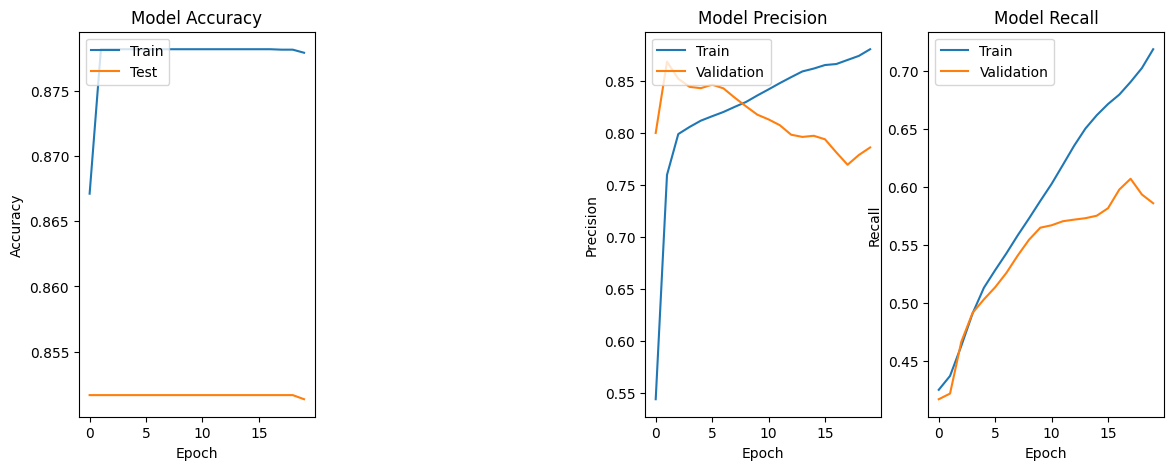

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))

# Plot training accuracy
plt.subplot(1, 4, 1)
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Precision
plt.subplot(1, 4, 3)
plt.plot(history_1.history['precision'])
plt.plot(history_1.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Recall
plt.subplot(1, 4, 4)
plt.plot(history_1.history['recall'])
plt.plot(history_1.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


/tmp/ipykernel_34/564279304.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 4, 3)


KeyError: 'precision'

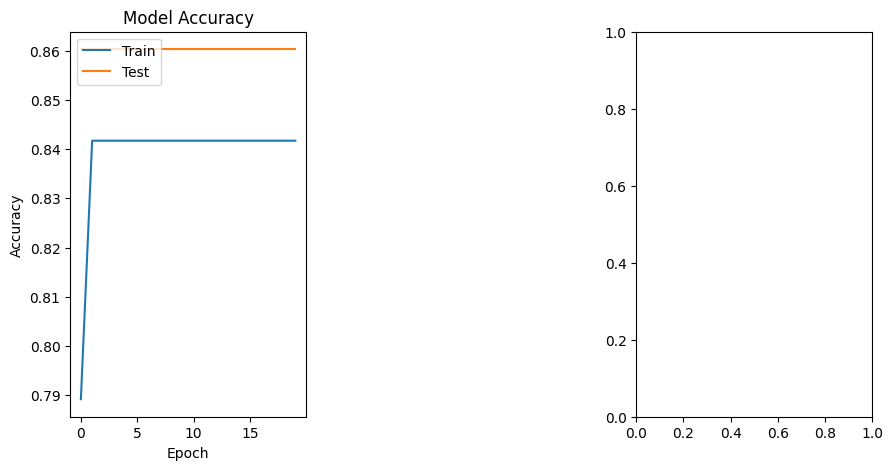

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))

# Plot training accuracy
plt.subplot(1, 4, 1)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Precision
plt.subplot(1, 4, 3)
plt.plot(history_2.history['precision'])
plt.plot(history_2.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Recall
plt.subplot(1, 4, 4)
plt.plot(history_2.history['recall'])
plt.plot(history_2.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


/tmp/ipykernel_34/1863169876.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 4, 3)


KeyError: 'precision'

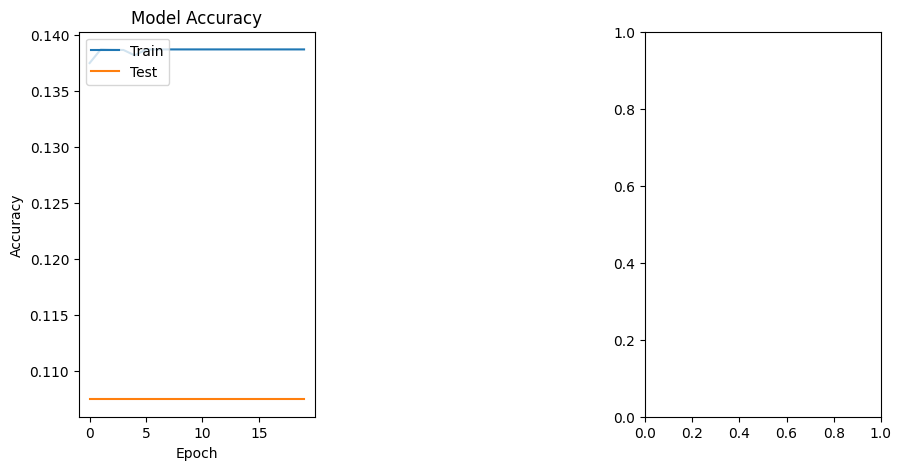

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))

# Plot training accuracy
plt.subplot(1, 4, 1)
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Precision
plt.subplot(1, 4, 3)
plt.plot(history_3.history['precision'])
plt.plot(history_3.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Recall
plt.subplot(1, 4, 4)
plt.plot(history_3.history['recall'])
plt.plot(history_3.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
